In [283]:
# Importing libraries 
import pandas as pd
import numpy as np
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import matplotlib.pyplot as plt
import seaborn as sns
# import links as lk

### Google Sheets Sign-Up

In [284]:
# Set Up Authentication for google sheets
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name("credentials.json", scope)
client = gspread.authorize(creds)

# Open Google Sheet by URL
sheet_url = "sheet_url"
sheet = client.open_by_url(sheet_url).sheet1  # First sheet

# Convert Sheet Data to Pandas DataFrame
data = sheet.get_all_values()
df = pd.DataFrame(data)

In [285]:
# Set First Row as Column Names
df.columns = df.iloc[0]  # Assign first row as headers
df = df[1:]  # Remove the first row from data

# Drop Unnecessary Columns
df = df.drop(df.columns[11:], axis=1)  # Drop all columns from index 9 onward
print("Column names:", df.columns.tolist())  # Check the column names

df.head()

Column names: ['Timestamp', 'Device', 'Temperature (C)', 'Temperature (F)', 'Humidity', 'ADC', 'Voltage', 'Pressure', 'Airspeed', 'Co2', 'Occupancy']


,Timestamp,Device,Temperature (C),Temperature (F),Humidity,ADC,Voltage,Pressure,Airspeed,Co2,Occupancy
1,2025-03-11 08:36:38,Pico_1,29.9,85.82,64.2,N/A,N/A,N/A,N/A,N/A,1
2,2025-03-11 08:36:51,Pico_1,29.8,85.64,65.1,N/A,N/A,N/A,N/A,N/A,1
3,2025-03-11 08:37:02,Pico_1,29.8,85.64,65,N/A,N/A,N/A,N/A,N/A,1
4,2025-03-11 08:37:14,Pico_1,29.8,85.64,65,N/A,N/A,N/A,N/A,N/A,1
5,2025-03-11 08:37:26,Pico_1,29.8,85.64,65,N/A,N/A,N/A,N/A,N/A,1


### Data Cleaning

In [286]:
# Converting N/A values to 0 and changing data types
var = ['Temperature (C)','Temperature (F)', 'Humidity', 'ADC', 'Voltage', 'Pressure', 'Airspeed', 'Co2']
df['Timestamp'] = pd.to_datetime(df['Timestamp']) # Convert Timestamp to datetime
for var in var:
    df[var] = df[var].replace('N/A', '0', regex=True).astype(float)  # Replace N/A with 0 and convert to float
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 1 to 920
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Timestamp        920 non-null    datetime64[ns]
 1   Device           920 non-null    object        
 2   Temperature (C)  920 non-null    float64       
 3   Temperature (F)  920 non-null    float64       
 4   Humidity         920 non-null    float64       
 5   ADC              920 non-null    float64       
 6   Voltage          920 non-null    float64       
 7   Pressure         920 non-null    float64       
 8   Airspeed         920 non-null    float64       
 9   Co2              920 non-null    float64       
 10  Occupancy        920 non-null    object        
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 79.2+ KB


In [287]:
# Creating a column to differentiate between the timings of the data
df["Time_Diff"] = df["Timestamp"].diff().dt.total_seconds() # Calculate time difference between rows
df["Batch"] = (df["Time_Diff"] > 120).cumsum() # Create batch number based on time difference
df = df.drop(columns=["Time_Diff"])         # Drop the time difference column
latest_batch = df["Batch"].max()          # Get the latest batch number
data = df[df["Batch"] == latest_batch].copy() # Filter the latest batch data
data.head()

,Timestamp,Device,Temperature (C),Temperature (F),Humidity,ADC,Voltage,Pressure,Airspeed,Co2,Occupancy,Batch
361,2025-03-16 16:41:19,Pico_1,27.9,82.22,62.5,0.0,0.0,0.0,0.0,725.0342,1,29
362,2025-03-16 16:42:07,Pico_1,28.1,82.58,63.4,0.0,0.0,0.0,0.0,505.0502,1,29
363,2025-03-16 16:42:41,Pico_1,28.1,82.58,63.4,0.0,0.0,0.0,0.0,699.9499,1,29
364,2025-03-16 16:43:14,Pico_1,28.1,82.58,63.5,0.0,0.0,0.0,0.0,695.0147,1,29
365,2025-03-16 16:43:47,Pico_1,28.1,82.58,64.0,0.0,0.0,0.0,0.0,715.0396,1,29


In [288]:
# Identify rows to drop based on the condition in CO2 column
drop_indices = []

for i in range(1, len(data) - 1):  # Start from index 1 to avoid out-of-bounds errors
    if (abs(data["Co2"].iloc[i-1] - data["Co2"].iloc[i]) > 100 and 
        abs(data["Co2"].iloc[i] - data["Co2"].iloc[i+1]) > 100 and 
        abs(data["Co2"].iloc[i-1] - data["Co2"].iloc[i+1]) < 100 and data["Co2"].iloc[i] != 0):
        
        drop_indices.append(data.index[i])  # Store index to drop

# Drop the identified rows which
data = data.drop(index=drop_indices).reset_index(drop=True)
data.head()

,Timestamp,Device,Temperature (C),Temperature (F),Humidity,ADC,Voltage,Pressure,Airspeed,Co2,Occupancy,Batch
0,2025-03-16 16:41:19,Pico_1,27.9,82.22,62.5,0.0,0.0,0.0,0.0,725.0342,1,29
1,2025-03-16 16:42:41,Pico_1,28.1,82.58,63.4,0.0,0.0,0.0,0.0,699.9499,1,29
2,2025-03-16 16:43:14,Pico_1,28.1,82.58,63.5,0.0,0.0,0.0,0.0,695.0147,1,29
3,2025-03-16 16:43:47,Pico_1,28.1,82.58,64.0,0.0,0.0,0.0,0.0,715.0396,1,29
4,2025-03-16 16:44:20,Pico_1,28.1,82.58,64.4,0.0,0.0,0.0,0.0,735.0118,1,29


In [289]:
# Swap 0 with avg of previous and next values
variables = ["Co2", "Temperature (C)", "Temperature (F)", "Humidity", "ADC", "Voltage", "Pressure", "Airspeed"]

# Iterate over each variable
for v in variables:
    for i in range(1, len(data) - 1):  # Avoid index out-of-bounds errors
        if data[v].iloc[i] == 0 and data[v].iloc[i-1] != 0 and data[v].iloc[i+1] != 0:
            # Use .at[] to avoid SettingWithCopyWarning and properly update values
            data.at[data.index[i], v] = (data[v].iloc[i-1] + data[v].iloc[i+1]) / 2

# Drop Batch Columns
data = data.drop(data.columns[11:], axis=1)  # Drop all columns from index 9 onward
print("Column names:", data.columns.tolist())  # Check the column names

data.head()


Column names: ['Timestamp', 'Device', 'Temperature (C)', 'Temperature (F)', 'Humidity', 'ADC', 'Voltage', 'Pressure', 'Airspeed', 'Co2', 'Occupancy']


,Timestamp,Device,Temperature (C),Temperature (F),Humidity,ADC,Voltage,Pressure,Airspeed,Co2,Occupancy
0,2025-03-16 16:41:19,Pico_1,27.9,82.22,62.5,0.0,0.0,0.0,0.0,725.0342,1
1,2025-03-16 16:42:41,Pico_1,28.1,82.58,63.4,0.0,0.0,0.0,0.0,699.9499,1
2,2025-03-16 16:43:14,Pico_1,28.1,82.58,63.5,0.0,0.0,0.0,0.0,695.0147,1
3,2025-03-16 16:43:47,Pico_1,28.1,82.58,64.0,0.0,0.0,0.0,0.0,715.0396,1
4,2025-03-16 16:44:20,Pico_1,28.1,82.58,64.4,0.0,0.0,0.0,0.0,735.0118,1


In [290]:
data_pico_1 = data[data["Device"] == "Pico_1"].copy() # Filter data for Pico_1
data_pico_2 = data[data["Device"] == "Pico_2"].copy() # Filter data for Pico_2

In [291]:
# Filter data for Pico_1 and Pico_2
data_pico_1 = data_pico_1.reset_index(drop=True)
data_pico_2 = data_pico_2.reset_index(drop=True)

# Define the expected variables for each Pico
pico_1_vars = ["Temperature (C)", "Temperature (F)", "Humidity", "Co2", "Occupancy"]
pico_2_vars = ["ADC", "Voltage", "Pressure", "Airspeed"]

# Initialize a list to store matched results
merged_data = []

# Compare each row in Pico_1 with the closest Pico_2 row within 15-20 seconds
for index, row in data_pico_1.iterrows():
    # Find the closest Pico_2 row within the 15-20 second time gap
    matched_rows = data_pico_2[
        (data_pico_2["Timestamp"] >= row["Timestamp"] - pd.Timedelta(seconds=20)) & 
        (data_pico_2["Timestamp"] <= row["Timestamp"] + pd.Timedelta(seconds=20))
    ]

    if not matched_rows.empty:
        # Take the closest match (smallest time difference)
        closest_match = matched_rows.iloc[(matched_rows["Timestamp"] - row["Timestamp"]).abs().argmin()]

        # Combine the data into a single row
        merged_data.append({
            "Pico_1_Timestamp": row["Timestamp"],
            "Pico_2_Timestamp": closest_match["Timestamp"],
            "Time_Difference": abs((row["Timestamp"] - closest_match["Timestamp"]).total_seconds()),  # Time diff in seconds
            **{f"{col}": row[col] for col in pico_1_vars if col in data_pico_1.columns},
            **{f"{col}": closest_match[col] for col in pico_2_vars if col in data_pico_2.columns}
        })

# Convert merged data to DataFrame
merged_df = pd.DataFrame(merged_data)
merged_df.head()

,Pico_1_Timestamp,Pico_2_Timestamp,Time_Difference,Temperature (C),Temperature (F),Humidity,Co2,Occupancy,ADC,Voltage,Pressure,Airspeed
0,2025-03-16 17:32:08,2025-03-16 17:32:09,1.0,29.7,85.46,69.7,419.9931,0,680.0,0.034241,-2465.7590,0.00
1,2025-03-16 17:33:14,2025-03-16 17:33:02,12.0,29.7,85.46,69.5,414.9776,0,736.0,0.037061,-2462.9390,0.00
2,2025-03-16 18:03:20,2025-03-16 18:03:15,5.0,28.7,83.66,75.0,419.9763,0,392.0,0.019739,-2480.2610,0.00
3,2025-03-16 18:12:53,2025-03-16 18:12:54,1.0,28.6,83.48,75.4,425.0836,0,65535.0,3.300000,799.9998,131.15
4,2025-03-16 18:13:59,2025-03-16 18:13:47,12.0,28.5,83.30,75.8,419.8913,0,65535.0,3.300000,799.9998,131.15


In [292]:
data_cleaned = merged_df.copy()  # Create a copy of the merged data
data_cleaned = data_cleaned.drop(columns=["Pico_2_Timestamp", "Time_Difference"])  # Drop timestamp columns
data_cleaned = data_cleaned.rename(columns={"Pico_1_Timestamp": "Timestamp"})  # Rename Pico_1 timestamp column
data_cleaned = data_cleaned.sort_values(by="Timestamp").reset_index(drop=True)  # Sort by timestamp
data_cleaned.head()

,Timestamp,Temperature (C),Temperature (F),Humidity,Co2,Occupancy,ADC,Voltage,Pressure,Airspeed
0,2025-03-16 17:32:08,29.7,85.46,69.7,419.9931,0,680.0,0.034241,-2465.7590,0.00
1,2025-03-16 17:33:14,29.7,85.46,69.5,414.9776,0,736.0,0.037061,-2462.9390,0.00
2,2025-03-16 18:03:20,28.7,83.66,75.0,419.9763,0,392.0,0.019739,-2480.2610,0.00
3,2025-03-16 18:12:53,28.6,83.48,75.4,425.0836,0,65535.0,3.300000,799.9998,131.15
4,2025-03-16 18:13:59,28.5,83.30,75.8,419.8913,0,65535.0,3.300000,799.9998,131.15


### Data Visualization 

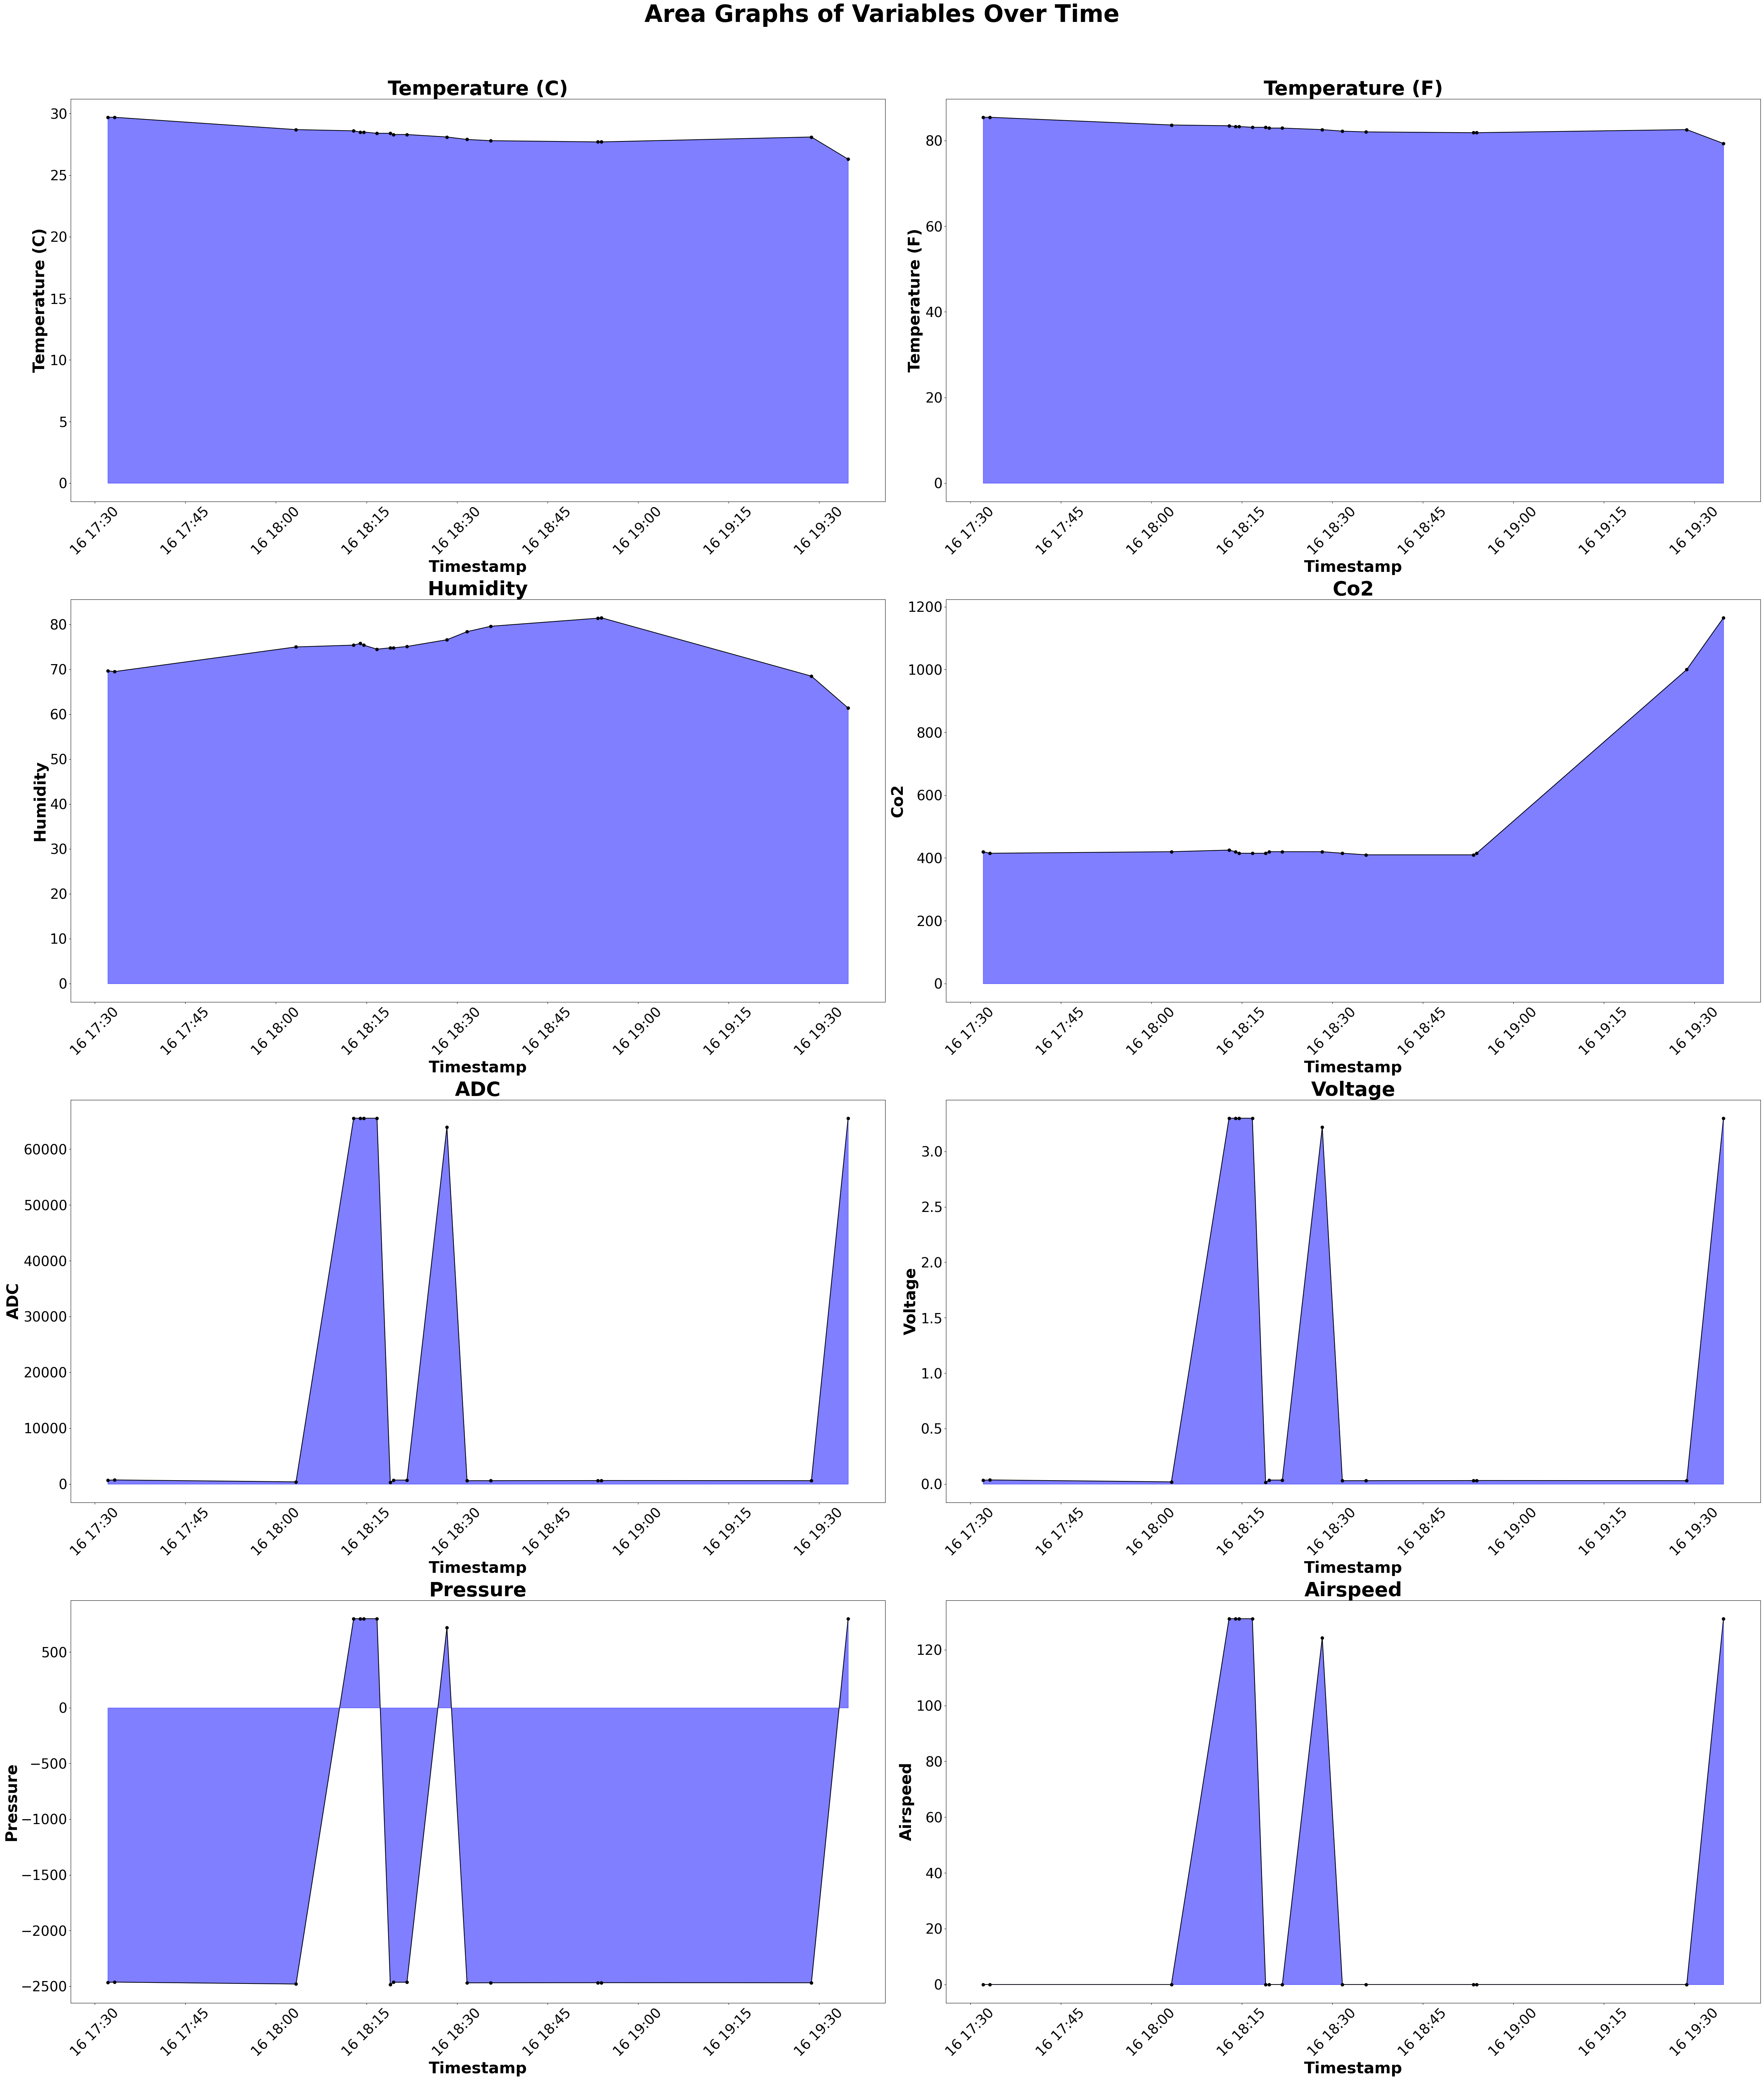

In [293]:
# Create 4x2 subplots with a larger figure size
fig, axes = plt.subplots(4, 2, figsize=(50, 60))
fig.suptitle("Area Graphs of Variables Over Time", fontsize=48, fontweight='bold')  # Larger title

# Flatten axes array for easy iteration
axes = axes.flatten()
variables = ["Temperature (C)", "Temperature (F)", "Humidity", "Co2", "ADC", "Voltage", "Pressure", "Airspeed"]

# Plot each variable
for i, var in enumerate(variables):
    ax = axes[i]
    ax.fill_between(data_cleaned["Timestamp"], data_cleaned[var], alpha=0.5, color="blue")
    ax.plot(data_cleaned["Timestamp"], data_cleaned[var], marker="o", linestyle="-", color="black")
    
    # Increase font sizes
    ax.set_title(var, fontsize=40, fontweight='bold')  # Larger title
    ax.set_xlabel("Timestamp", fontsize=32, fontweight='bold')  # Larger x-axis label
    ax.set_ylabel(var, fontsize=32, fontweight='bold')  # Larger y-axis label
    ax.tick_params(axis='x', rotation=45, labelsize=28)  # Larger tick labels
    ax.tick_params(axis='y', labelsize=28)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


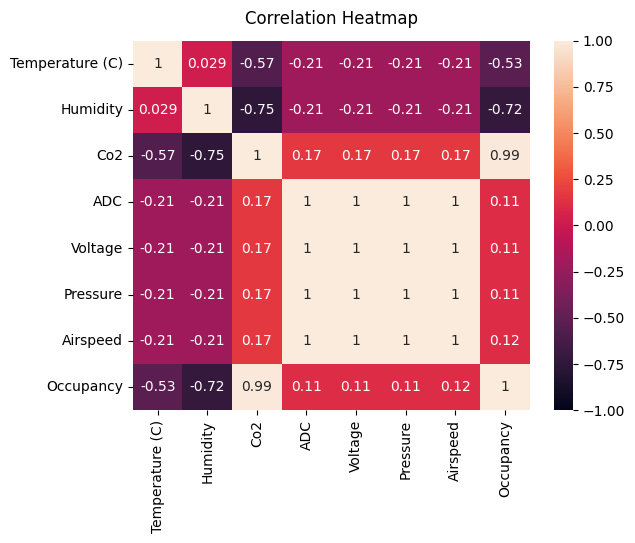

In [294]:
x = ['Temperature (C)', 'Humidity', 'Co2', 'ADC', 'Voltage', 'Pressure', 'Airspeed', 'Occupancy']
heatmap = sns.heatmap(data_cleaned[x].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()


### Models 

#### Wells - Riley Equation

In [295]:
def calculate_risk(co2, occupancy, airflow, exposure_time=60, room_volume=100):
    # Define the infectious dose and other parameters
    I = 0.000001  # Example value for infectious dose
    C = airflow  # Airflow rate in m³/min
    V = room_volume  # Volume of the room in m³
    t = exposure_time  # Exposure time in minutes
    P = 1 - np.exp(-I * t / (V * C))  # Infection probability formula
    return P

#### Time Series - ARIMA 